# Introduction to LangGraph

In this tutorial, we will build a support chatbot in LangGraph that can:
- Answer common questions by searching the Web.
- Maintain conversation state across calls.
- Route complex queries to a human for review.
- Use custom state to control its behavior.
- Rewind and explore alternative conversation paths.

We will:
- start with a basic chatbot,
- progressively add more sophisticated capabilities

This will allow us to introduce key LangGraph concepts along the way.

# Setup

In [5]:
import os

from dotenv import load_dotenv
from rich import print as rprint

In [7]:
_ = load_dotenv()
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

# 1. Build a Basic Chatbot

We'll first create a simple chatbot using LangGraph.

This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, you will have a built rudimentary chatbot.

- Start by instanciating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a *"state machine"*.
- We'll add:
    - ` nodes` to represent:
        - the llm,
        - functions our chatbot can call;
    - `edges` to specify how the bot should transition between these `nodes`


In [10]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

> - **STACK OVERFLOW**: [**How to use python `typing.Annotated`**](https://stackoverflow.com/questions/71898644/how-to-use-python-typing-annotated)
> - **DOCUMENTATION**: [**typing_extensions**](https://typing-extensions.readthedocs.io/en/latest/#)

## Defining `State` and Instanciating `StateGraph`

In [11]:
# Define the data type of the state with a State class
class State(TypedDict):
    """
    Messages have the type `list`. The `add_messages` function in the annotation
    defines how this state key should be updated (with this function then)
    (in this case, it happens messages to the list, rather than overwriting them)
    """
    messages: Annotated[list, add_messages]

# Instanciate a StateGraph object, linked to this State class
graph_builder = StateGraph(State)

### Some Introspection

In [15]:
type(graph_builder)

langgraph.graph.state.StateGraph

In [22]:
rprint(graph_builder)

<langgraph.graph.state.StateGraph object at 0x7b57356177d0>

In [17]:
sg_attrs = [item for item in dir(graph_builder) if item[0] != "_"]
sg_attrs

['add_conditional_edges',
 'add_edge',
 'add_node',
 'branches',
 'channels',
 'compile',
 'compiled',
 'config_schema',
 'edges',
 'managed',
 'nodes',
 'schema',
 'set_conditional_entry_point',
 'set_entry_point',
 'set_finish_point',
 'support_multiple_edges',
 'validate',
 'waiting_edges']

> This `StateGraph` object contains all the attributes and methods needed to build a graph, adding components like nodes and edges, and defining an entrypoint.

### Explanations

Notice that we've defined our `State` as a `TypedDict` with a single key: `messages`.

The `messages` key is annotated with the `add_messages` function, which tells LangGraph to append messages to the existing list, rather than overwriting it.

So, our new graph knows two things:
1. Every `node` we define will:
    - receive the current `State` as input,
    - return a value that updates this state.
2. `messages` will be **appended** to the current list, rather than directly overwritten. This is specified via the prebuilt `add_messages` function in the `Annotated` syntax.

## Adding a "Chatbot" Node

**Nodes** represent **units of work**.

They're typically regular python functions.

In [18]:
from langchain_openai import ChatOpenAI

In [19]:
# Instanciate LLM
llm = ChatOpenAI(model="gpt-3.5-turbo")

# Define unit of work
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [20]:
# The first argument is the node's name
# The second one is the name of the function called when the node is used
graph_builder.add_node("chatbot", chatbot)

### Explanations

Notice how the `chatbot` node function:
- takes the current `State` as input,
- returns an updated `messages` list.

This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our `State` will append the llm's response messages to whatever messages are already in the state.

## Set an Entry Point

This will tell our graph **where to start to work** each time we run it.

In [24]:
graph_builder.set_entry_point("chatbot")

## Set a Finish Point

Similarly, this will instruct the graph **"any time this node is run, you can exit"**.

In [25]:
graph_builder.set_finish_point("chatbot")

## Compile

Finally we want to be able to run our graph.

To do so, call `compile` method on the graph builder, which will create a `CompiledGraph` we can use to invoke on our state.

In [26]:
graph = graph_builder.compile()

### Introspection

In [27]:
type(graph)

langgraph.graph.state.CompiledStateGraph

In [28]:
graph.__class__.__mro__

(langgraph.graph.state.CompiledStateGraph,
 langgraph.graph.graph.CompiledGraph,
 langgraph.pregel.Pregel,
 langchain_core.runnables.base.RunnableSerializable,
 langchain_core.load.serializable.Serializable,
 pydantic.v1.main.BaseModel,
 pydantic.v1.utils.Representation,
 langchain_core.runnables.base.Runnable,
 typing.Generic,
 abc.ABC,
 object)

In [29]:
[item for item in dir(graph) if item[0] != "_"]

['Config',
 'InputType',
 'OutputType',
 'abatch',
 'abatch_as_completed',
 'aget_state',
 'aget_state_history',
 'ainvoke',
 'assign',
 'astream',
 'astream_events',
 'astream_log',
 'atransform',
 'attach_branch',
 'attach_edge',
 'attach_node',
 'aupdate_state',
 'auto_validate',
 'batch',
 'batch_as_completed',
 'bind',
 'builder',
 'channels',
 'checkpointer',
 'config_schema',
 'config_specs',
 'config_type',
 'configurable_alternatives',
 'configurable_fields',
 'construct',
 'copy',
 'debug',
 'dict',
 'from_orm',
 'get_graph',
 'get_input_schema',
 'get_lc_namespace',
 'get_name',
 'get_output_schema',
 'get_prompts',
 'get_state',
 'get_state_history',
 'input_channels',
 'input_schema',
 'interrupt_after_nodes',
 'interrupt_before_nodes',
 'invoke',
 'is_lc_serializable',
 'json',
 'lc_attributes',
 'lc_id',
 'lc_secrets',
 'managed_values_dict',
 'map',
 'name',
 'nodes',
 'output_channels',
 'output_schema',
 'parse_file',
 'parse_obj',
 'parse_raw',
 'pick',
 'pipe',
 're

## Visualize the Graph

You can visualize the graph  using:
- the `get_graph` method,
- one of the "draw" method like, for example:
    - `draw_ascii`,
    - `draw_png`...

Notice that the `draw` methods each require additional dependencies.

In [41]:
# List the different available methods
[item for item in dir(graph.get_graph()) if item.startswith("draw")]

['draw_ascii', 'draw_mermaid', 'draw_mermaid_png', 'draw_png']

In [30]:
from IPython.display import Image, display

> The following code raises a weird error which will be investigated later.

In [36]:
# try:
#     display(Image(graph.get_graph().draw_ascii()))
# except Exception as e:
#     print(e)  # Needs grandalf package

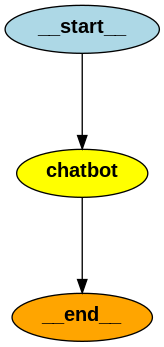

In [37]:
try:
    display(Image(graph.get_graph().draw_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

> Raises a weird error that should be fixed later too...

In [43]:
# try:
#     display(Image(graph.get_graph().draw_mermaid()))
# except Exception:
#     # This requires some extra dependencies and is optional
#     pass

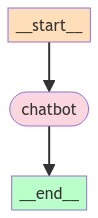

In [44]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

> Adopt either style you prefer or try several depending on circumstances.

## Run the Chatbot

In [48]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ("quit", "exit", "q"):
        rprint("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            rprint("Assistant: ", value["messages"][-1].content)

Assistant:  LangGraph is a language learning platform that uses AI technology to help users improve their language 
skills through interactive lessons, personalized feedback, and real-time practice exercises. The platform offers 
courses in various languages, including English, Spanish, French, and German, and caters to learners of all levels,
from beginners to advanced speakers. LangGraph also provides users with progress tracking tools, study reminders, 
and a community forum where they can connect with other language learners.

Goodbye!

## Inspect the LangSmith Trace

At the provided link.

## Limits

You may have noticed that **the bot's knowledge is limited to what's in its training data**.

In the next part, **we will add a Web search tool to expand the bot's knowledge** and make it more capable.

# 2. Enhancing the Chatbot With Tools

To handle queries our chatbot can't answer "from memory", we'll **integrate a Web search tool**.

Our bot can use this tool to find relevant information and provide better responses.

## Define the Tool

In [49]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [50]:
tool = TavilySearchResults(max_results=2)

tools = [tool]

In [52]:
rprint(tool.invoke("What is a 'node' in LangGraph?"))

[
    {
        'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
        'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a 
computation step. You define nodes to perform specific tasks, such as processing input, making ...'
    },
    {
        'url': 'https://www.ionio.ai/blog/a-comprehensive-guide-about-langgraph-code-included',
        'content': 'A node can be any function or tool your agent uses in langgraph and these nodes are connected 
with other nodes using edges. Every workflow ends with a "END" node in langgraph which shows the end of workflow. 
You also need to define a starting node which will be the starting point of your workflow. Optionally, you can also
define an ending ...'
    }
]

The results are **page summaries our chatbot can use to answer questions**.

Next, we will start defining our graph. The following will be **all the same as part 1, except we have added `bind_tools` to our LLM**.

This **lets the LLM know the correct JSON format to use if it wants to use our search engine**.

## Initiate Graph and Chatbot Node

In [72]:
graph_builder = StateGraph(State)

llm_with_tools = llm.bind_tools(tools)

graph_builder.add_node("chatbot", chatbot)

## Add a Tool Node

Next, we need to **create a function to actually run the tools if they are called**.

We'll do this by **adding the tools to a new node**.



Below, we will implement a `BasicToolNode` that:
- checks the most recent message in the state,
- calls tools if this message contains `tool_calls`.

**It relies on the LLM's tool_calling support**, which is available in Anthropic, Gemini, OpenAI and a number of other LLM providers.

> **NOTE**
>
> We will later replace this with LangGraph's prebuilt [`ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) to speed things up, but building it ourselves first is instructive.

In [73]:
import json

from langchain_core.messages import ToolMessage

In [74]:
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage"""

    def __init__(self, tools: list) -> None:
        # Create a mapping between tools' names and tools
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            messages = messages[-1]
        else:
            raise ValueError("No message found in input")
        
        outputs = []

        for tool_call in messages.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        
        return {"messages": outputs}

In [75]:
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

## Add Conditional Edges

With the tool node added, we can define `conditional_edges`.

Recall that **edges route the control flow from one node to another**.

**Conditional edges** usually contain `if` statements to route to different nodes depending on the current graph state.

These functions:
- receive the current graph state,
- return a string or a list of strings **indicating which node to call next**.

Below, we define **a router function** called `route_tools`.

It **checks for `tool_call`s in the chatbot's output**.

Provide this function to the graph by calling `add_conditional_edges`, which tells the graph that whenever the `chatbot` node completes, it's needed to check this function's output to check which node to go next.

The condition will route to:
- `"tools"` node if tool calls are present,
- `"__end__"` node if not.

> **NOTE**
> 
> Later, we will replace this by the prebuilt `tools_condition` to be more concise but implementing it first by ourselves will make things more clear.

In [76]:
from typing import Literal

In [77]:
def route_tools(state: State) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to:
    - the "tool" node if the last message has tool calls,
    - the "__end__" node otherwise.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

In [78]:
graph_builder.add_conditional_edges(
    "chatbot",  # Starting node
    route_tools,  # Decision function
    # A dictionary to map `route_tools` output to destination node
    {"tools": "tools", "__end__": "__end__"}
)

In [79]:
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

### Explanations

Conditional edges start from a single node.

This tells the graph that anytime the `"chatbot"` node runs, either:
- go to `"tools"` node if it calls a tool,
- end the loop if it responds directly.

When the graph transitions to `"__end__"`, it has no more tasks to complete and hence ceases execution.

Because the condition can return `"__end__"`, we don't need to explicitely use `set_finish_point` this time, as our graph as already a point to finish.

## Visualize the Graph

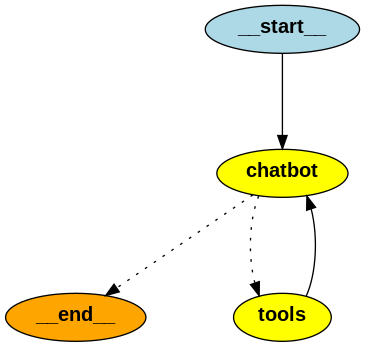

In [80]:
try:
    display(Image(graph.get_graph().draw_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

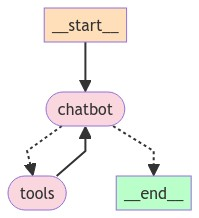

In [81]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Ask the Chatbot Questions Outside its Training Data

In [82]:
from langchain_core.messages import BaseMessage

In [85]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ("quit", "exit", "q"):
        rprint("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                rprint("Assistant:", value["messages"][-1].content)

Assistant: The teams confronted in the NBA Finals 2024 were the Los Angeles Lakers and the Brooklyn Nets.

Assistant: I'm sorry, but I am unable to provide real-time weather updates. I recommend checking a reliable weather
website or app for the most up-to-date information on the weather in San Francisco.

Goodbye!

> **NOTE**
> 
> **This output underlines there's still something to fix here!**

## Up to Date Full Snippet

### Imports

In [86]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from typing_extensions import TypedDict


### `State`

In [87]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

### Graph Builder, Tools, LLM

In [90]:
graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatOpenAI(model="gpt-3.5-turbo")
llm_with_tools = llm.bind_tools(tools)

### Nodes

In [91]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

### Edges

In [92]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")

### Set Entry Point and Compile

In [93]:
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

### Visualize Graph

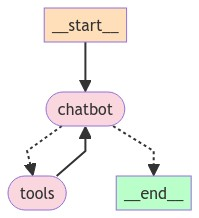

In [94]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Ask the Chatbot!

In [95]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ("quit", "exit", "q"):
        rprint("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                rprint("Assistant:", value["messages"][-1].content)

Assistant:

Assistant: [{"url": "https://www.nba.com/playoffs/2024/nba-finals", "content": "Find out the dates, times and 
broadcaster of the 2024 NBA Finals, as well as the latest news and highlights from the playoffs. Relive the moments
and champions of every NBA Finals since 2000."}, {"url": "https://www.nba.com/playoffs/2024", "content": "See the 
latest results and previews of the 2024 NBA playoffs, featuring the Celtics, Pacers, Wolves and Mavs in the 
conference finals. Find out who will face each other in the 2024 NBA Finals and watch the top plays and news of the
postseason."}]

Assistant: The teams in the NBA Finals 2024 are the Celtics, Pacers, Wolves, and Mavs.

Assistant:

Assistant: [{"url": "https://www.nba.com/playoffs/2024", "content": "The official site of the 2024 NBA Playoffs. 
Latest news, schedules, matchups, highlights, bracket and more."}, {"url": 
"https://www.espn.com/nba/story/_/id/39943302/nba-finals-2024-celtics-mavericks-news-scores-highlights", "content":
"The 2024 NBA Finals are here! Only two teams remain standing in the postseason as the best-of-seven series between
the Boston Celtics and the Dallas Mavericks tipped off on June 6 (watch every ..."}]

Assistant: The current round of the NBA Finals 2024 features the Boston Celtics and the Dallas Mavericks. The 
best-of-seven series between these two teams began on June 6. You can find more information on the official NBA 
Playoffs website (https://www.nba.com/playoffs/2024) and on ESPN's coverage 
(https://www.espn.com/nba/story/_/id/39943302/nba-finals-2024-celtics-mavericks-news-scores-highlights).

Goodbye!